In [24]:
# %pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
import pygad

In [25]:
def extract_data(file_path):
    ds = pd.read_json(file_path)
    # display(ds)
    preferences = np.array([list(row) for row in ds["preferences"]])
    friendships = np.array([list(row) for row in ds["friendships"]])
    authorship = np.array([list(row) for row in ds["authorship"]])
    capacity = ds["reviewer_capacity"][0]
    min_reviews = ds["min_reviews_per_paper"][0]
    max_reviews = ds["max_reviews_per_paper"][0]
    
    return  preferences, friendships, authorship, capacity, min_reviews, max_reviews


In [26]:
def fitness_function_impl(assignment, preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    # Total Preference Score
    preference_score = np.sum(assignment * preferences)
    max_preference_score = np.sum(np.max(preferences, axis=0))  # Max possible score
    normalized_preference_score = preference_score / max_preference_score

    # Capacity Violation
    capacity_violation = np.sum(np.maximum(0, np.sum(assignment, axis=1) - capacity))

    # Review Violations
    reviews_per_paper = np.sum(assignment, axis=0)
    review_violation = np.sum(np.maximum(0, min_reviews - reviews_per_paper)) + \
                       np.sum(np.maximum(0, reviews_per_paper - max_reviews))

    # Friendship Joint Review Violation
    friendship_violation = 0
    for i in range(len(friendships)):
        for j in range(len(friendships)):
            if friendships[i][j] == 1:
                friendship_violation += np.sum(assignment[i] * assignment[j])

    # Friends Reviewing Each Other's Papers
    friends_authorship_violation = 0
    num_reviewers, num_papers = assignment.shape
    for reviewer in range(num_reviewers):
        for paper in range(num_papers):
            for friend in range(num_reviewers):
                if friendships[reviewer][friend] == 1 and authorship[friend][paper] == 1:
                    friends_authorship_violation += assignment[reviewer][paper]

    # Authorship Violation
    authorship_violation = np.sum(assignment * authorship)

    # Weights for penalties
    w1, w2, w3, w4, w5 = 2, 3, 2, 3, 4  # Adjusted weights

    # Fitness
    fitness = normalized_preference_score - (w1 * capacity_violation + w2 * review_violation +
                                             w3 * friendship_violation + w4 * friends_authorship_violation +
                                             w5 * authorship_violation)

    # Bias towards non-zero assignments
    bias_reward = 0.01 * np.sum(assignment)  # Small reward for assignments
    fitness += bias_reward

    return fitness / (num_reviewers * num_papers)



In [27]:
def solution_capacity_min_reviews(preferences, capacity, min_reviews, max_reviews, friendships, authorship, seed=None):
    rng = np.random.default_rng(seed)
    num_reviewers, num_papers = preferences.shape
    # Initialize the matrix with zeros
    matrix = np.zeros((num_reviewers, num_papers), dtype=int)
    
    # Fill the matrix ensuring no more than K ones per row
    for i in range(num_reviewers):
        ones_to_place = rng.integers(0, capacity + 1)  # Randomly decide how many ones to place (up to K)
        columns = rng.choice(num_papers, ones_to_place, replace=False)  # Randomly select columns
        matrix[i, columns] = 1
    
    # Ensure at least S ones in each column
    for j in range(num_papers):
        current_ones = np.sum(matrix[:, j])
        if current_ones < min_reviews:
            additional_ones_needed = min_reviews - current_ones
            available_rows = [i for i in range(num_reviewers) if matrix[i, j] == 0 and np.sum(matrix[i, :]) < capacity]
            if len(available_rows) < additional_ones_needed:
                continue
            
            # Randomly add ones to meet the column constraint
            rows_to_fill = rng.choice(available_rows, additional_ones_needed, replace=False)
            for row in rows_to_fill:
                matrix[row, j] = 1
    
    return matrix


In [ ]:
def solution_randomized_general(preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = preferences.shape
    assignment = np.zeros((num_reviewers, num_papers), dtype=int)
    reviews_per_paper = np.zeros(num_papers, dtype=int)
    reviews_per_reviewer = np.zeros(num_reviewers, dtype=int)

    # Randomly shuffle the order of papers
    papers = np.arange(num_papers)
    np.random.shuffle(papers)

    for paper in papers:
        # Assign reviewers to this paper until min_reviews is met
        potential_reviewers = np.argsort(-preferences[:, paper])  # High preference reviewers first
        np.random.shuffle(potential_reviewers)  # Randomize potential reviewers order
        assigned_reviewers = 0

        for reviewer in potential_reviewers:
            # Check constraints
            if reviews_per_reviewer[reviewer] < capacity and \
               reviews_per_paper[paper] < max_reviews and \
               authorship[reviewer][paper] == 0 and \
               all(friendships[reviewer][friend] == 0 or authorship[friend][paper] == 0 for friend in range(num_reviewers)):
                # Assign the reviewer to the paper
                assignment[reviewer][paper] = 1
                reviews_per_reviewer[reviewer] += 1
                reviews_per_paper[paper] += 1
                assigned_reviewers += 1

                # Stop if we've met min_reviews for this paper
                if assigned_reviewers >= min_reviews:
                    break

    return assignment

In [29]:
def solution_general(preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = preferences.shape
    assignment = np.zeros((num_reviewers, num_papers))
    reviews_per_paper = np.zeros(num_papers)
    reviews_per_reviewer = np.zeros(num_reviewers)

    # Assign papers to reviewers
    for paper in range(num_papers):
        # Assign reviewers to this paper until min_reviews is met
        potential_reviewers = np.argsort(-preferences[:, paper])  # High preference reviewers first
        assigned_reviewers = 0
        for reviewer in potential_reviewers:
            # Check constraints
            if reviews_per_reviewer[reviewer] < capacity and \
               reviews_per_paper[paper] < max_reviews and \
               authorship[reviewer][paper] == 0 and \
               all(friendships[reviewer][friend] == 0 or authorship[friend][paper] == 0 for friend in range(num_reviewers)):
                # Assign the reviewer to the paper
                assignment[reviewer][paper] = 1
                reviews_per_reviewer[reviewer] += 1
                reviews_per_paper[paper] += 1
                assigned_reviewers += 1

                # Stop if we've met min_reviews for this paper
                if assigned_reviewers >= min_reviews:
                    break

    return assignment


In [30]:
def solution_random(preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = preferences.shape
    solution = np.zeros((num_reviewers, num_papers), dtype=int)
    for reviewer in range(num_reviewers):
        # Randomly assign up to 'reviewer_capacity' papers to each reviewer
        papers_to_assign = np.random.choice(num_papers, capacity, replace=False)
        solution[reviewer, papers_to_assign] = 1
    return solution

In [ ]:
def solution_authorship_constraint(preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = preferences.shape
    solution = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for reviewer in range(num_reviewers):
        # Exclude papers authored by the reviewer
        non_authored_papers = np.where(authorship[reviewer] == 0)[0]
        if len(non_authored_papers) >= capacity:
            papers_to_assign = np.random.choice(non_authored_papers, capacity, replace=False)
            solution[reviewer, papers_to_assign] = 1
    
    return solution


def solution_reviewers_constraint(preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = preferences.shape
    solution = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for paper in range(num_papers):
        # Randomly select the number of reviewers for this paper within the min-max range
        num_reviewers_for_paper = np.random.randint(min_reviews, max_reviews + 1)
        # Randomly select reviewers to assign this paper
        reviewers_to_assign = np.random.choice(num_reviewers, num_reviewers_for_paper, replace=False)
        solution[reviewers_to_assign, paper] = 1
        
    return solution


def solution_friendship_constraint(preferences, capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = preferences.shape
    solution = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for reviewer in range(num_reviewers):
        # Find the papers already assigned to the reviewer's friends
        friend_indices = np.where(friendships[reviewer] == 1)[0]
        papers_to_avoid = np.any(solution[friend_indices], axis=0)
        available_papers = np.where(papers_to_avoid == 0)[0]
        
        # Assign papers from available ones
        if len(available_papers) >= capacity:
            papers_to_assign = np.random.choice(available_papers, capacity, replace=False)
            solution[reviewer, papers_to_assign] = 1
    
    return solution

In [ ]:
def find_solution1(file_path, parent_selection_type,crossover_type,mutation_type, num_solutions):
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
        solution_capacity_min_reviews(preferences, capacity, min_reviews, max_reviews, friendships, authorship).flatten()
        # generate_random_solution(num_reviewers, num_papers, capacity).flatten()
        for _ in range(num_solutions)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )



    ga_instance = pygad.GA(
    num_generations=200,
    num_parents_mating=40,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=5
    )


    # Run the genetic algorithm
    ga_instance.run()

    solution, best_solution_fitness, _ = ga_instance.best_solution()

    best_assignment = solution.reshape((num_reviewers, num_papers))

    return best_assignment, best_solution_fitness, ga_instance
    

In [32]:
find_solution1("datasets/easy_dataset_1.json", "tournament", "two_points", "random", 50)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")



Best solution fitness: -0.18854545454545452


In [ ]:
def find_solution2(file_path, parent_selection_type,crossover_type,mutation_type, num_solutions, num_parents_mating):
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
        # generate_valid_solution(num_reviewers, num_papers, capacity, min_reviews).flatten()
        solution_general(preferences, capacity, min_reviews, max_reviews, friendships, authorship).flatten()
        # generate_random_solution(num_reviewers, num_papers, capacity).flatten()
        for _ in range(num_solutions + 1)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )

    def custom_crossover(parents, offspring_size, ga_instance):
        
        num_parents, num_genes = parents.shape
        offspring = np.empty(offspring_size, dtype=parents.dtype)
        
        child_index = 0  # To keep track of the child being created
        
        while child_index < offspring_size[0]:
            # Select two parents
            parent1_idx = np.random.randint(0, num_parents)
            parent2_idx = np.random.randint(0, num_parents)
            
            while parent2_idx == parent1_idx:
                parent2_idx = np.random.randint(0, num_parents)
            
            # Reshape parents into matrices
            parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
            parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))
            
            # Initialize child matrices
            child1_matrix = np.empty_like(parent1_matrix)
            child2_matrix = np.empty_like(parent2_matrix)
            
            # Row-wise crossover for two children
            for row in range(num_reviewers):
                if np.random.rand() < 0.5:
                    child1_matrix[row] = parent1_matrix[row]
                    child2_matrix[row] = parent2_matrix[row]
                else:
                    child1_matrix[row] = parent2_matrix[row]
                    child2_matrix[row] = parent1_matrix[row]
            
            # Flatten child matrices into 1D and store in offspring
            offspring[child_index] = child1_matrix.flatten()
            child_index += 1
            
            if child_index < offspring_size[0]:
                offspring[child_index] = child2_matrix.flatten()
                child_index += 1
        
        return offspring
    
    def custom_mutation(offspring, ga_instance):
        num_children, num_genes = offspring.shape
        mutation_percent_genes = ga_instance.mutation_percent_genes

        # Calculate the number of genes to mutate per child
        num_mutations = max(1, int((mutation_percent_genes / 100) * num_genes))

        for child_index in range(num_children):
            # Randomly select `num_mutations` genes to mutate for the current child
            mutation_indices = np.random.choice(num_genes, size=num_mutations, replace=False)

            # Flip the value of the selected genes
            for gene_index in mutation_indices:
                offspring[child_index, gene_index] = 1 - offspring[child_index, gene_index]

        return offspring
   


    ga_instance = pygad.GA(
    num_generations=100,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=custom_crossover,
    mutation_type=custom_mutation,           # Custom mutation
    mutation_percent_genes=2
    )


    # Run the genetic algorithm
    ga_instance.run()

    solution, best_solution_fitness, _ = ga_instance.best_solution()

    best_assignment = solution.reshape((num_reviewers, num_papers))

    return best_assignment, best_solution_fitness, ga_instance
    

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=2) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign


Best solution fitness: -0.18854545454545452
Best Assignment Matrix:
 [[1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1.]]


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


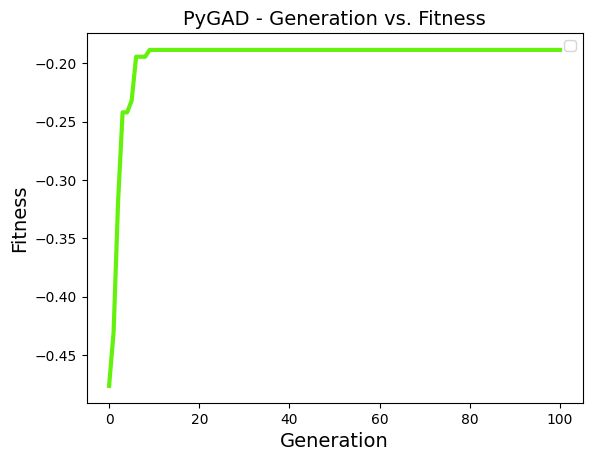

In [34]:
find_solution2("datasets/easy_dataset_1.json", "tournament", "two_points", "random", 150, 60)

In [ ]:
# CUSTOM CROSSOVERS AND MUTATIONS

### Column wise crossover
def custom_crossover_columns(parents, offspring_size, ga_instance):
    num_parents, num_genes = parents.shape
    offspring = np.empty(offspring_size, dtype=parents.dtype)

    child_index = 0  # To track the current child being created
    num_reviewers, num_papers = offspring_size[1] // parents.shape[1], parents.shape[1]

    while child_index < offspring_size[0]:
        # Select two random, distinct parents
        parent1_idx = np.random.randint(0, num_parents)
        parent2_idx = np.random.randint(0, num_parents)

        while parent2_idx == parent1_idx:
            parent2_idx = np.random.randint(0, num_parents)

        # Reshape parents into matrices
        parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
        parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))

        # Initialize child matrices
        child1_matrix = np.empty_like(parent1_matrix)
        child2_matrix = np.empty_like(parent2_matrix)

        # Column-wise crossover for two children
        for col in range(num_papers):
            if np.random.rand() < 0.5:
                child1_matrix[:, col] = parent1_matrix[:, col]
                child2_matrix[:, col] = parent2_matrix[:, col]
            else:
                child1_matrix[:, col] = parent2_matrix[:, col]
                child2_matrix[:, col] = parent1_matrix[:, col]

        # Flatten child matrices into 1D and store in offspring
        offspring[child_index] = child1_matrix.flatten()
        child_index += 1

        if child_index < offspring_size[0]:
            offspring[child_index] = child2_matrix.flatten()
            child_index += 1

    return offspring



def custom_crossover_rows(parents, offspring_size, ga_instance):
        
    num_reviewers, num_papers = offspring_size[1] // parents.shape[1], parents.shape[1]
    num_parents, num_genes = parents.shape
    offspring = np.empty(offspring_size, dtype=parents.dtype)
    
    child_index = 0  # To keep track of the child being created
    
    while child_index < offspring_size[0]:
        # Select two parents
        parent1_idx = np.random.randint(0, num_parents)
        parent2_idx = np.random.randint(0, num_parents)
        
        while parent2_idx == parent1_idx:
            parent2_idx = np.random.randint(0, num_parents)
        
        # Reshape parents into matrices
        parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
        parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))
        
        # Initialize child matrices
        child1_matrix = np.empty_like(parent1_matrix)
        child2_matrix = np.empty_like(parent2_matrix)
        
        # Row-wise crossover for two children
        for row in range(num_reviewers):
            if np.random.rand() < 0.5:
                child1_matrix[row] = parent1_matrix[row]
                child2_matrix[row] = parent2_matrix[row]
            else:
                child1_matrix[row] = parent2_matrix[row]
                child2_matrix[row] = parent1_matrix[row]
        
        # Flatten child matrices into 1D and store in offspring
        offspring[child_index] = child1_matrix.flatten()
        child_index += 1
        
        if child_index < offspring_size[0]:
            offspring[child_index] = child2_matrix.flatten()
            child_index += 1
    
    return offspring


### Uniform crossover
def custom_crossover_uniform(parents, offspring_size, ga_instance):
    num_parents, num_genes = parents.shape
    offspring = np.empty(offspring_size, dtype=parents.dtype)

    child_index = 0  # Track the current child being created
    num_reviewers, num_papers = offspring_size[1] // parents.shape[1], parents.shape[1]

    while child_index < offspring_size[0]:
        # Select two random, distinct parents
        parent1_idx = np.random.randint(0, num_parents)
        parent2_idx = np.random.randint(0, num_parents)

        while parent2_idx == parent1_idx:
            parent2_idx = np.random.randint(0, num_parents)

        # Reshape parents into matrices
        parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
        parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))

        # Initialize child matrices
        child_matrix = np.empty_like(parent1_matrix)

        # Uniform crossover: Assign each gene randomly from one of the two parents
        for i in range(num_reviewers):
            for j in range(num_papers):
                if np.random.rand() < 0.5:
                    child_matrix[i, j] = parent1_matrix[i, j]
                else:
                    child_matrix[i, j] = parent2_matrix[i, j]

        # Flatten the child matrix into 1D and store in offspring
        offspring[child_index] = child_matrix.flatten()
        child_index += 1

    return offspring


### Heuristic crossover
def custom_crossover_heuristic(parents, offspring_size, ga_instance):
    num_parents, num_genes = parents.shape
    offspring = np.empty(offspring_size, dtype=parents.dtype)

    # Fitness values for the parents
    parent_fitness = np.array([ga_instance.fitness_func(p, ga_instance) for p in parents])

    for child_index in range(offspring_size[0]):
        # Select two parents
        parent1_idx, parent2_idx = np.random.choice(range(num_parents), size=2, replace=False)

        # Select the fitter parent with higher probability
        if parent_fitness[parent1_idx] > parent_fitness[parent2_idx]:
            fitter_parent, other_parent = parents[parent1_idx], parents[parent2_idx]
        else:
            fitter_parent, other_parent = parents[parent2_idx], parents[parent1_idx]

        # Generate the offspring biased toward the fitter parent
        offspring[child_index] = np.where(
            np.random.rand(num_genes) < 0.7,  # Bias probability for fitter parent's genes
            fitter_parent,
            other_parent
        )

    return offspring


### Matrix crossover
def custom_crossover_matrix(parents, offspring_size, ga_instance):
    num_reviewers, num_papers = offspring_size[1] // parents.shape[1], parents.shape[1]
    num_parents, num_genes = parents.shape
    offspring = np.empty(offspring_size, dtype=parents.dtype)

    for child_index in range(offspring_size[0]):
        # Select two parents
        parent1_idx, parent2_idx = np.random.choice(range(num_parents), size=2, replace=False)

        # Reshape into matrices
        parent1_matrix = parents[parent1_idx].reshape((num_reviewers, num_papers))
        parent2_matrix = parents[parent2_idx].reshape((num_reviewers, num_papers))

        # Divide parents into quadrants
        mid_row, mid_col = num_reviewers // 2, num_papers // 2

        # Create offspring by recombining quadrants
        child_matrix = np.block([
            [parent1_matrix[:mid_row, :mid_col], parent2_matrix[:mid_row, mid_col:]],
            [parent2_matrix[mid_row:, :mid_col], parent1_matrix[mid_row:, mid_col:]]
        ])

        # Flatten the child matrix into a 1D array
        offspring[child_index] = child_matrix.flatten()

    return offspring


### Two-point crossover
def custom_crossover_two_point(parents, offspring_size, ga_instance):
    num_parents, num_genes = parents.shape
    offspring = np.empty(offspring_size, dtype=parents.dtype)

    for child_index in range(offspring_size[0]):
        # Select two parents
        parent1_idx, parent2_idx = np.random.choice(range(num_parents), size=2, replace=False)

        # Select two random crossover points
        point1, point2 = sorted(np.random.choice(range(num_genes), size=2, replace=False))

        # Create the offspring
        offspring[child_index] = np.concatenate([
            parents[parent1_idx][:point1],
            parents[parent2_idx][point1:point2],
            parents[parent1_idx][point2:]
        ])

    return offspring



### AUTHORSHIP BASED MUTATION
def custom_mutation_authorship(child, friendships, authorship, mutation_probability):
        
    child = child.reshape((authorship.shape))
    authorship_breaches = child * authorship
    mutated_child = child - authorship_breaches

    return mutated_child.flatten()


### FRIENDSHIP BASED MUTATION
def custom_mutation_friendship(child, friendships, authorship, mutation_probability):
    child = child.reshape((authorship.shape))
    num_reviewers, num_papers = child.shape
    for reviewer in range(num_reviewers):
        for paper in range(num_papers):
            for friend in range(num_reviewers):
                if friendships[reviewer][friend] == 1 and authorship[friend][paper] == 1 and child[reviewer][paper] == 1:
                    child[reviewer][paper] = 0
    return child.flatten()


### ROW WISE MUTATION
def custom_mutation_row_wise(child, friendships, authorship, mutation_probability):
    # Reshape offspring into a matrix
    num_reviewers, num_papers = authorship.shape
    child_matrix = child.reshape((num_reviewers, num_papers))

    # Randomly select rows for mutation
    for row in range(num_reviewers):
        if np.random.rand() < mutation_probability:
            # Flip random values in the row
            mutation_indices = np.random.choice(num_papers, size=1, replace=False)
            child_matrix[row, mutation_indices] = 1 - child_matrix[row, mutation_indices]

    # Flatten the matrix back

    return child_matrix.flatten()


### COLUMN WISE MUTATION
def custom_mutation_column_wise(child, friendships, authorship, mutation_probability):
    # Reshape offspring into a matrix
    num_reviewers, num_papers = authorship.shape
    child_matrix = child.reshape((num_reviewers, num_papers))

    # Randomly select columns for mutation
    for col in range(num_papers):
        if np.random.rand() < mutation_probability:
            # Flip random values in the column
            mutation_indices = np.random.choice(num_reviewers, size=1, replace=False)
            child_matrix[mutation_indices, col] = 1 - child_matrix[mutation_indices, col]

    # Flatten the matrix back

    return child_matrix.flatten()


### BLOCK MUTATION
def custom_mutation_block(child, friendships, authorship, mutation_probability, block_size=(2, 2)):
    # Reshape offspring into a matrix
    num_reviewers, num_papers = authorship.shape
    child_matrix = child.reshape((num_reviewers, num_papers))

    if np.random.rand() < mutation_probability:
        # Select random starting points for the block
        row_start = np.random.randint(0, num_reviewers - block_size[0] + 1)
        col_start = np.random.randint(0, num_papers - block_size[1] + 1)

        # Flip values within the block
        for i in range(block_size[0]):
            for j in range(block_size[1]):
                row, col = row_start + i, col_start + j
                child_matrix[row, col] = 1 - child_matrix[row, col]

    # Flatten the matrix back

    return child_matrix.flatten()


### SWAP MUTATION
def custom_mutation_swap(child, friendships, authorship, mutation_probability):
    if np.random.rand() < mutation_probability:
        # Select two random indices to swap
        num_genes = len(child)
        idx1, idx2 = np.random.choice(num_genes, size=2, replace=False)

        # Swap the values
        child[idx1], child[idx2] = child[idx2], child[idx1]

    return child


In [ ]:
def find_solution3(file_path, parent_selection_type,crossover_type, mutation_type, num_solutions, num_parents_mating):
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
  
        solution_randomized_general(preferences, capacity, min_reviews, max_reviews, friendships, authorship).flatten()
        for _ in range(num_solutions + 1)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )

    def custom_crossover(parents, offspring_size, ga_instance):
        return crossover_type(parents, offspring_size, ga_instance)
    
    def custom_mutation(offspring, ga_instance):
        num_children, num_genes = offspring.shape
        

        for child_index in range(num_children):
            
            offspring[child_index] = mutation_type(offspring[child_index], friendships, authorship, ga_instance.mutation_percent_genes)

        return offspring
   


    ga_instance = pygad.GA(
    num_generations=150,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=custom_crossover,
    mutation_type=custom_mutation,           # Custom mutation
    mutation_percent_genes=2,
    keep_elitism=10
    )


    # Run the genetic algorithm
    ga_instance.run()

    solution, best_solution_fitness, _ = ga_instance.best_solution()

    best_assignment = solution.reshape((num_reviewers, num_papers))

    return best_assignment, best_solution_fitness, ga_instance
    

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=2) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign


Best solution fitness atanas: -0.19440000000000002


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


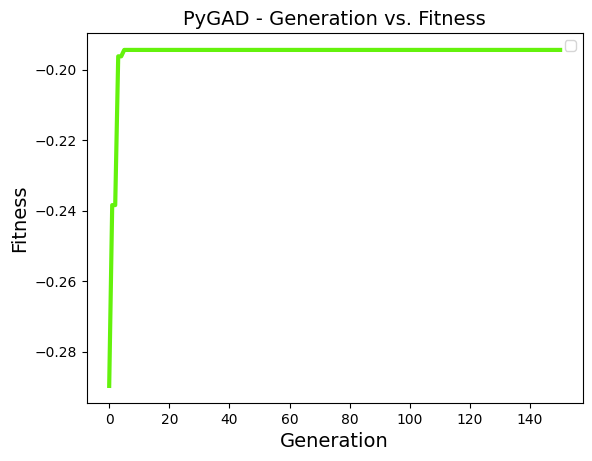

In [37]:
find_solution3("datasets/easy_dataset_1.json", "tournament", custom_crossover_columns, custom_mutation_authorship, 150, 40)
# find_solution1("datasets/hard_dataset_1.json", "tournament", "two_points", "random", 150)

In [38]:
def find_solution_final(file_path, parent_selection_type,crossover_type, mutation_type, num_solutions, \
                        num_parents_mating, num_generations, initial_solution, mutation_percent_genes, elitism):
    
    preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data(file_path)
    num_reviewers, num_papers = preferences.shape


    initial_population = [
        initial_solution(preferences, capacity, min_reviews, max_reviews, friendships, authorship).flatten()
        for _ in range(num_solutions + 1)
    ]

    def fitness_function(ga_instance, solution, solution_idx):
        # Reshape the 1D solution to a 2D assignment matrix
        assignment = solution.reshape((num_reviewers, num_papers))
    
        # Ensure binary values in the assignment matrix
        assignment = np.clip(assignment, 0, 1)

        # Calculate fitness using the provided fitness function
        return fitness_function_impl(
            assignment,
            preferences,
            capacity,
            min_reviews,
            max_reviews,
            friendships,
            authorship
        )

    def custom_crossover(parents, offspring_size, ga_instance):
        return crossover_type(parents, offspring_size, ga_instance)
    
    def custom_mutation(offspring, ga_instance):
        num_children, num_genes = offspring.shape
        

        for child_index in range(num_children):
            
            offspring[child_index] = mutation_type(offspring[child_index], friendships, authorship, ga_instance.mutation_percent_genes)

        return offspring
   


    ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=len(initial_population),
    num_genes=num_reviewers * num_papers,  # Flattened assignment matrix
    gene_space=[0,1],
    initial_population=initial_population,  # Custom initial population
    parent_selection_type=parent_selection_type,
    crossover_type=custom_crossover,
    mutation_type=custom_mutation,           # Custom mutation
    mutation_percent_genes=mutation_percent_genes,
    keep_elitism=elitism
    )


    # Run the genetic algorithm
    ga_instance.run()

    solution, best_solution_fitness, _ = ga_instance.best_solution()

    best_assignment = solution.reshape((num_reviewers, num_papers))

    return best_assignment, best_solution_fitness, ga_instance
    

In [44]:
best_assignment, best_solution_fitness, ga_instance = find_solution_final(file_path = "datasets/medium_dataset_1.json", \
                                                                        parent_selection_type = "tournament",\
                                                                        crossover_type = custom_crossover_columns,\
                                                                        mutation_type = custom_mutation_authorship, \
                                                                        num_solutions = 150, \
                                                                        num_parents_mating = 50, \
                                                                        num_generations = 100, \
                                                                        initial_solution = solution_randomized_general, \
                                                                        mutation_percent_genes = 2, \
                                                                        elitism = 10)


# print("Best Assignment Matrix:\n", best_assignment)
print("Best solution fitness:", best_solution_fitness)

# ga_instance.plot_fitness()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best solution fitness: -0.13946504559270517


In [48]:
preferences, friendships, authorship, capacity, min_reviews, max_reviews = extract_data("datasets/easy_dataset_1.json")
num_reviewers, num_papers = preferences.shape


initial_population = [
    solution_general(preferences, capacity, min_reviews, max_reviews, friendships, authorship).flatten()
    for _ in range(10 + 1)
]

for population in initial_population:
    print(population.reshape((num_reviewers, num_papers)))

[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]]